# Fit Example

In this tutorial we will see how to use ironman to fit the parameters of a system for which we have photometry, out-of-transit radial velocities and in-transit radial velocities, with the objective of measuring the sky-projected obliquity

In [59]:
import ironman
import pandas as pd
import numpy as np

First thing we need is to open the different datasets. In this case we will only use some TESS photometry, HARPS radial velocities, and ESPRESSO in-transit radial velocities. The more datasets we use, the more constrained the parameters will be

In [60]:
tess = pd.read_csv("../Example_data_WASP-139/TESS_Y1_LC.csv")
bjd_tess1 = tess.time.values
flux_tess1 = tess.flux.values
flux_err_tess1 = tess.flux_err.values

tess = pd.read_csv("../Example_data_WASP-139/TESS_Y2_LC.csv")
bjd_tess2 = tess.time.values
flux_tess2 = tess.flux.values
flux_err_tess2 = tess.flux_err.values

harps = pd.read_csv("../Example_data_WASP-139/HARPS_RV.txt")
time_harps = harps["BJD"].values
rv_harps = harps['RV'].values
rv_err_harps = harps['RVe'].values

espresso = pd.read_csv("../Example_data_WASP-139/ESPRESSO_RV.csv")
time_espresso = espresso["Time"].values
rv_espresso = espresso["RV (km/s)"].values * 1000.0
rv_err_espresso = espresso["RV err (km/s)"].values * 1000.0

Photometric data must be in normalized flux. RV data must be in m/s.

Then we can create the dictionaries to input them into the DataOrg

In [61]:
times_lc, fluxes, fluxes_error = {}, {}, {}
times_rvs, rvs, rvs_err =  {}, {}, {}
times_RM, RM, RM_err =  {}, {}, {}

times_lc["TESSY1"], fluxes["TESSY1"], fluxes_error["TESSY1"] = bjd_tess1, flux_tess1, flux_err_tess1
times_lc["TESSY2"], fluxes["TESSY2"], fluxes_error["TESSY2"] = bjd_tess2, flux_tess2, flux_err_tess2

times_rvs["HARPS"], rvs["HARPS"], rvs_err["HARPS"] = time_harps, rv_harps, rv_err_harps

times_RM["ESPRESSO"], RM["ESPRESSO"], RM_err["ESPRESSO"] = time_espresso, rv_espresso, rv_err_espresso

If you have data from more instruments, you just have to add them to the respective dictionaries using the respective key.
#### Important note:
If you have data taken with the same spectrograph for the in-transit and out-of-transit radial velocities, you should add it to the RM dictionaries only (unless you explicitly want to consider them as different instruments).

One mandatory argument for the DataOrg are the exposure times. This is important to super sample the models. The exposure times must be included in ironman as a dictionary. All instruments for the photometry and RM effect must be included in the dictionary. It is mandatory for the RM data to include the exposure times. For the photometry, if you don't want to do super sampling, you can set the value to False.

#### All exposure times must be in days

In [62]:
exp_times = {"TESSY1":False,"TESSY2":False,"ESPRESSO": 600.0/60.0/60.0/24.0}

Then, we input all the dictionaries to the DataOrg

In [50]:
my_data = ironman.Data_Org(lc_time=times_lc,lc_flux=fluxes,lc_flux_err=fluxes_error,rv_time=times_rvs,rv=rvs,rv_err=rvs_err,rm_time=times_RM,rm=RM,rm_err=RM_err,verbose = True,exp_times=exp_times)

Reading LCs...
Reading RVs...
Reading RM data...


Then we need to set out priors for the different parameters. In ironman this is done with a file like the one in the example.

Necessary parameters to model the system are:

    - lam_p1: Sky-projeced obliquity (deg)
    - vsini_star: Projected rotational velocity of the star (km/s)
    - per_p1: Orbital period (days)
    - t0_p1: Transit midpoint (BJD)
    - aRs_p1: Semimajor axis (in units of Rstar) 
    - inc_p1: Orbital inclination (deg)
    - p_p1: Planet radius (in units of Rstar)
    - e_p1: Orbital eccentricity
    - omega_p1: Argument of periastron (deg)
    - K_p1: RV semiamplitude (km/s)
    - gammadot: 
    - gammadotdot:

The code also accepts alternative parameterizations:

    - rho_star: Stellar density (kg/m3) -> Instead of aRs_p1
    - b_p1: Impact parameter -> Instead of inc_p1

If the objective is to measure the true 3D obliquity, given some constraints in the rotational period and radius of the star, the parametrization can be changed. In particular, the code accepts 3 parameters instead of vsini_star:

    - r_star: Radius of the host star (Rsun)
    - Prot_star: Rotational period of the host star (days)
    - cosi_star: Cosine of the stellar inclination

Those are the "physical" parameters of the code. Depending on the instruments, some additional parameters are required. For the photometry:

    - q1_instrument: Linear limb darkening parameter
    - q2_instrument: Quadratic limb darkening parameter
    - sigma_instrument: Photometric jitter added in quadrature to the errors. It must be in the same units as the errors.

Instead of q1 and q2 (from Kipping 2013), the code can also directly accept u1 and u2 (the quadratic limb darkening parameters). For instruments used for the Keplerian RVs the necessary instrumental parameters are:

    - gamma_instrument: RV offset (m/s)
    - sigma_instrument: RV jitter added in quadrature to the RV errors. Must be in m/s

Finally, for the instruments used to measure the RM effect, the necessary parameters are:

    - q1_instrument: Linear limb darkening parameter
    - q2_instrument: Quadratic limb darkening parameter
    - beta_instrument: Intrinsic stellar line width (km/s). It considers instrumental al macroturbulence broadening.
    - gamma_instrument: RV offset (m/s)
    - sigma_instrument: RV jitter added in quadrature to the RV errors. Must be in m/s

### The current version of the code is sensitive to the order of the instrumental parameters in the file. For now, need to follow the same order than here, or in the example priors file

Once we have a priors file, we can create the Priors class with it and the previous DataOrg class

In [51]:
my_priors = ironman.Priors("Example1_priors.dat",my_data)

Priors dictionary ready...
Detecting fixed parameters...
Fixed sigma_TESSY1 detected!
Fixed sigma_TESSY2 detected!
Fixed sigma_HARPS detected!
Fixed sigma_ESPRESSO detected!
Fixed gammadot detected!
Fixed gammadotdot detected!


Then we create the Fit class with the Priors and the DataOrg, and run it!

The recommended number of live points to run dynesty is at least $n^2$, with $n$ being the number of free parameters. For this tutorial 500 will do the trick

In [52]:
my_fit = ironman.Fit(my_data,my_priors)
post_samples = my_fit.run(n_live=500, nthreads = 24)

Running dynesty with 500 nlive and 24 threads


29366it [02:42, 180.39it/s, batch: 4 | bound: 36 | nc: 1 | ncall: 1021270 | eff(%):  2.826 | loglstar: 14572.028 < 14581.854 < 14579.089 | logz: 14544.339 +/-  0.203 | stop:  0.757]       


Once it finishes, we can save the post samples, and evaluate the results in a different code. To do that, we just read the samples again, and input them into the Post class together with our previous DataOrg, Priors and Fit.

In [53]:
np.savetxt('Example1_postsamples.txt', post_samples)
post_samples = np.loadtxt('Example1_postsamples.txt')

With the DataOrg, Priors, and Fit classes, we can create the Post class which will help us with the posterior analysis.

The first thing it does when created, is to print the values of each parameter (median, minus, plus)

In [54]:
my_post = ironman.Post(my_data,my_priors,my_fit,post_samples)

lam_p1 -77.22920547342399 13.675834660268336 15.88916075027214
vsini_star 0.7702313560325047 0.2509655002016493 0.2970113518758115
per_p1 5.92426987859764 8.958963348959514e-07 8.407623548478682e-07
t0_p1 2456870.9582580226 0.0002682148478925228 0.00026662740856409073
rho_star 2294.235737214901 133.85035157872016 121.73775778586696
b_p1 0.4370516302962437 0.09036585489965476 0.06239866141004402
p_p1 0.09999940010295609 0.0017883208018954488 0.0013803070923983085
e_p1 0.2701378245395852 0.03539371400130614 0.03392782956444462
omega_p1 192.51510108313892 8.009120842528603 7.56445683806362
K_p1 18.658963639946403 2.373644571580897 2.278543222478035
q1_TESSY1_TESSY2 0.44039634797722393 0.1766964882855891 0.2533346813192374
q2_TESSY1_TESSY2 0.2016462668895291 0.12230383735189493 0.2153866949883181
gamma_HARPS -13010.30928712472 1.5706089258874272 1.6023555366773508
q1_ESPRESSO 0.543413044202978 0.3348432417143522 0.3097056566358968
q2_ESPRESSO 0.5298316934725785 0.34882879600279804 0.316195

Even with the limited data, and the small number of live points, we found a set of constraints fully consistent with the ones we report in Espinoza-Retamal et al. (2024) for WASP-139b

With the Post class, we can get the different models to plot it with the data.

To do that, we need to call the evaluate_*_model function. The inputs are the times at which we want to evaluate the model, and the instrument.
Additionally, if you want to plot the $1\sigma$, $2\sigma$, and $3\sigma$ models, the functions can return many models.
You only need to set the models input to True, and give a number of models to return. 

In [55]:
times_espresso = my_post.data.x["ESPRESSO"]
times_models_espresso = np.linspace(times_espresso[0],times_espresso[-1],5000)
rm_model, rm_models = my_post.evaluate_RM_model(times_models_espresso,"ESPRESSO",models=True,number_models=5000)
rm_model_obs = my_post.evaluate_RM_model(times_espresso,"ESPRESSO",models=False)

The variable rm_model constains the best model evaluated at times with enough cadence to plot it properly, while rm_models contains 5000 random models from the chain. 

The variable rm_model_obs contains the model evaluated at the times of observations to get the residuals of the model.

Plots similar to the ones in Espinoza-Retamal et al. (2024) can be done with this code

0.0


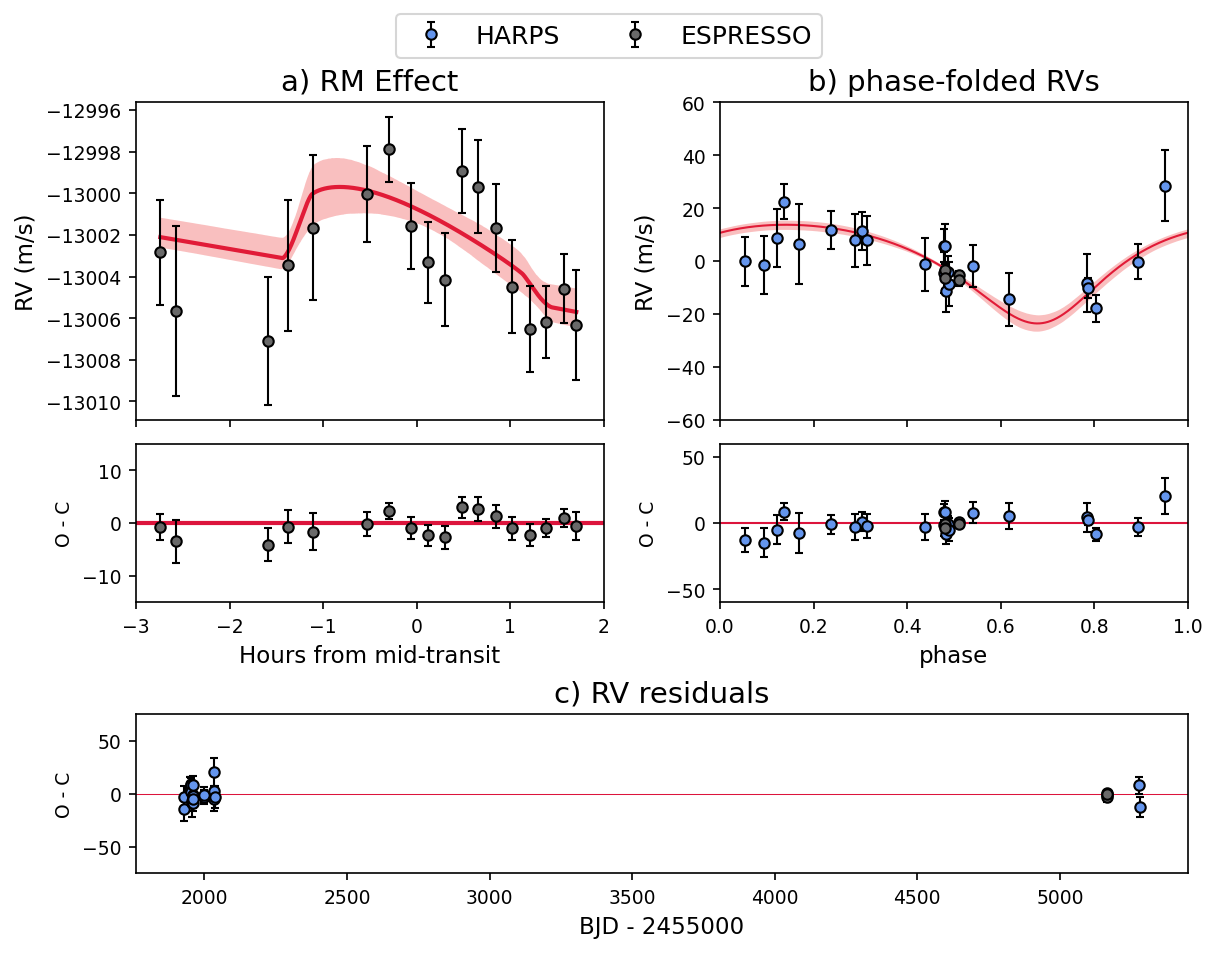

In [64]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,8),dpi=150,constrained_layout=True)
gs = fig.add_gridspec(6, 6)
ax1 = fig.add_subplot(gs[:2, :3])
ax2 = fig.add_subplot(gs[2, :3], sharex = ax1)
ax3 = fig.add_subplot(gs[:2,3:])
ax4 = fig.add_subplot(gs[2,3:], sharex = ax3)
ax5 = fig.add_subplot(gs[3, :])

t0 = my_post.vals["t0_p1"]
P = my_post.vals["per_p1"]

############################################ RM Effect

jitter = my_post.vals["sigma_ESPRESSO"]
times_model_plot = (times_models_espresso-t0-556*P)*24.
times, data, error = my_post.data.x["ESPRESSO"],my_post.data.y["ESPRESSO"],np.sqrt(my_post.data.yerr["ESPRESSO"]**2.0 + jitter**2.0)
times = (times-t0-556*P)*24. #556 corresponds to the number of the transit (i.e. the ESPRESSO transit midpoint was at t_i = 556 * per + t0 )
ax1.plot(times_model_plot,rm_model,lw=2,color="crimson",zorder=-10)
ax1.fill_between(times_model_plot,np.quantile(rm_models,0.16,axis=0),np.quantile(rm_models,0.84,axis=0),alpha=0.3,color="#EE2C2C",lw=0,zorder=-1)
ax1.errorbar(times,data,error,fmt="o",color="k",capsize=2,elinewidth=1,markerfacecolor="dimgrey")
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.set_ylabel('RV (m/s)',fontsize=11)
ax1.set_title("a) RM Effect", fontsize=14)

res = data-rm_model_obs
ax2.errorbar(times,res,error,fmt="o",color="k",capsize=2,elinewidth=1,markerfacecolor="dimgrey")
ax2.axhline(0.0,lw=2,color="crimson",zorder=-10)
ax2.set_ylim(-15,15)
ax2.set_xticks([-3,-2,-1,0,1,2])
ax2.set_xlabel(r'Hours from mid-transit',fontsize=11)
ax2.set_ylabel('O - C')

######################################## RV time

times_harps = my_post.data.x["HARPS"]
times_espresso = my_post.data.x["ESPRESSO"]
first_n = times_espresso[:2]
last_k = times_espresso[-2:]
times_espresso = np.concatenate((first_n, last_k))
times_models = np.concatenate((times_harps,times_espresso))
times_models = np.linspace(times_models.min(),times_models.max(),5000)

rv_model, rv_model_trend, rv_model_gamma, rv_models = my_post.evaluate_RV_model(times_models,"HARPS",models=True,number_models=5000)
rv_model_harps, rv_trend_harps, gamma_harps = my_post.evaluate_RV_model(times_harps,"HARPS",models=False)
rv_model_espresso, rv_trend_espresso, gamma_espresso = my_post.evaluate_RV_model(times_espresso,"ESPRESSO",models=False)

jitter_harps = my_post.vals["sigma_HARPS"]
jitter_espresso = my_post.vals["sigma_ESPRESSO"]
data_harps, error_harps = my_post.data.y["HARPS"], np.sqrt(my_post.data.yerr["HARPS"]**2.0 + jitter_harps**2.0)
data_espresso, error_espresso = my_post.data.y["ESPRESSO"], np.sqrt(my_post.data.yerr["ESPRESSO"]**2.0 + jitter_espresso**2.0)
first_n = data_espresso[:2] #To include the ESPRESSO out-of-transit RVs in the plot
last_k = data_espresso[-2:]
data_espresso = np.concatenate((first_n, last_k))
first_n = error_espresso[:2]
last_k = error_espresso[-2:]
error_espresso = np.concatenate((first_n, last_k))

res_harps = data_harps-rv_model_harps-rv_trend_harps-gamma_harps
res_espresso = data_espresso-rv_model_espresso-rv_trend_espresso-gamma_espresso

ax5.errorbar(times_harps - 2455000,res_harps,error_harps,fmt="o",color="k",capsize=2,elinewidth=1,markerfacecolor="cornflowerblue")
ax5.errorbar(times_espresso - 2455000,res_espresso,error_espresso,fmt="o",color="k",capsize=2,elinewidth=1,markerfacecolor="dimgrey")
ax5.axhline(0.0,lw=0.5,color="crimson",zorder=-10)
ax5.set_title("c) RV residuals", fontsize=14)
ax5.set_xlabel(r'BJD - 2455000',fontsize=11)
ax5.set_ylabel('O - C')
ax5.set_ylim(-75,75)

############################################# RV Phase

phase_harps = ((times_harps-t0 + 0.5*P) % P)/P
phase_espresso = ((times_espresso-t0 + 0.5*P) % P)/P
phase_models = ((times_models-t0 + 0.5*P) % P)/P
idx = np.argsort(phase_models)

ax3.plot(phase_models[idx],(rv_model+rv_model_trend)[idx],lw=1.,color="crimson",zorder=-10)
ax3.fill_between(phase_models[idx],np.quantile(rv_models,0.16,axis=0)[idx],np.quantile(rv_models,0.84,axis=0)[idx],alpha=0.3,color="#EE2C2C",lw=0,zorder=-1) #1sigma models
#ax3.fill_between(phase_models[idx],np.quantile(rv_models,0.02,axis=0)[idx],np.quantile(rv_models,0.98,axis=0)[idx],alpha=0.2,color="#EE2C2C",lw=0,zorder=-1) #2sigma models
#ax3.fill_between(phase_models[idx],np.quantile(rv_models,0.0015,axis=0)[idx],np.quantile(rv_models,0.9985,axis=0)[idx],alpha=0.2,color="#EE2C2C",lw=0,zorder=-1) #3sigma models
ax3.errorbar(phase_harps,data_harps-rv_trend_harps-gamma_harps,error_harps,fmt="o",color="k",capsize=2,elinewidth=1,markerfacecolor="cornflowerblue",label="HARPS")
ax3.errorbar(phase_espresso,data_espresso-rv_trend_espresso-gamma_espresso,error_espresso,fmt="o",color="k",capsize=2,elinewidth=1,markerfacecolor="dimgrey",label="ESPRESSO")
ax3.set_title("b) phase-folded RVs", fontsize=14)
ax3.set_ylabel('RV (m/s)',fontsize=11)
plt.setp(ax3.get_xticklabels(), visible=False)
ax3.set_ylim(-60,60)
ax3.set_xlim(0,1)

ax4.errorbar(phase_harps,res_harps,error_harps,fmt="o",color="k",capsize=2,elinewidth=1,markerfacecolor="cornflowerblue")
ax4.errorbar(phase_espresso,res_espresso,error_espresso,fmt="o",color="k",capsize=2,elinewidth=1,markerfacecolor="dimgrey")
ax4.axhline(0.0,lw=1.,color="crimson",zorder=-10)
ax4.set_xlabel(r'phase',fontsize=11)
ax4.set_ylabel('O - C')
ax4.set_ylim(-60,60)

fig.set_facecolor('w')
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),ncol=3, fancybox=True, fontsize=12)
plt.show()
plt.close()

And for the photometric data

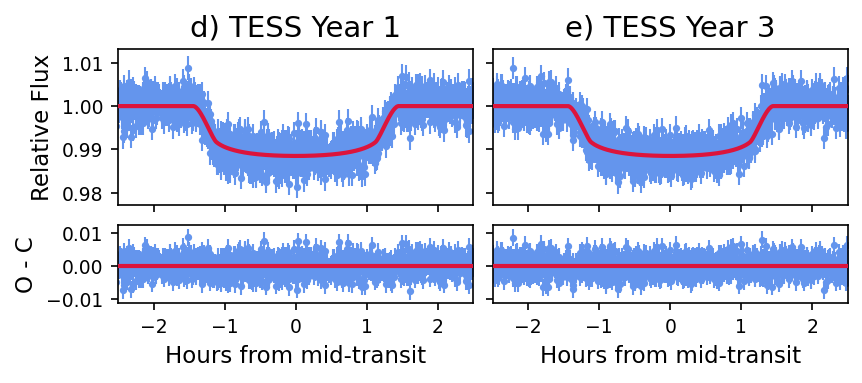

In [57]:
fig = plt.figure(figsize=(8,4),dpi=150,constrained_layout=True)
gs = fig.add_gridspec(6, 12)

ax7 = fig.add_subplot(gs[:2, 2:6])
ax8 = fig.add_subplot(gs[2, 2:6], sharex=ax7)
ax9 = fig.add_subplot(gs[:2, 6:10], sharey=ax7,sharex=ax7)
ax10 = fig.add_subplot(gs[2, 6:10],sharex=ax7,sharey=ax8)

times_TESSY1 = my_post.data.x["TESSY1"]
lc_model_TESSY1 = my_post.evaluate_LC_model(times_TESSY1,"TESSY1")
jitter_TESSY1 = my_post.vals["sigma_TESSY1"]
phase_TESSY1 = ((times_TESSY1-t0 + 0.5*P) % P)/P
idx = np.argsort(phase_TESSY1)
data_TESSY1, error_TESSY1 = my_post.data.y["TESSY1"], np.sqrt(my_post.data.yerr["TESSY1"]**2.0 + jitter_TESSY1**2.0)
ax7.plot((phase_TESSY1[idx]-0.5)*P*24.,lc_model_TESSY1[idx],lw=2,color="crimson",zorder=10)
ax7.errorbar((phase_TESSY1-0.5)*P*24.,data_TESSY1,error_TESSY1,fmt=".",color="cornflowerblue",elinewidth=1)
ax7.set_yticks([0.98,0.99,1,1.01])
ax7.set_xlim(-2.5,2.5)
ax7.set_xticks([-2,-1,0,1,2])
plt.setp(ax7.get_xticklabels(), visible=False)
ax7.set_ylabel('Relative Flux',size=11)
ax7.set_title("d) TESS Year 1",fontsize=14)
res_TESSY1 = data_TESSY1-lc_model_TESSY1
ax8.errorbar((phase_TESSY1-0.5)*P*24.,res_TESSY1,error_TESSY1,fmt=".",color="cornflowerblue",elinewidth=1)
ax8.axhline(0.0,lw=2,color="crimson",zorder=10)
#ax8.set_xlim(-3,3)
ax8.set_xlabel(r'Hours from mid-transit',size=11)
ax8.set_ylabel('O - C',size=11)

times_TESSY2 = my_post.data.x["TESSY2"]
lc_model_TESSY2 = my_post.evaluate_LC_model(times_TESSY2,"TESSY2")
jitter_TESSY2 = my_post.vals["sigma_TESSY2"]
phase_TESSY2 = ((times_TESSY2-t0 + 0.5*P) % P)/P
idx = np.argsort(phase_TESSY2)
data_TESSY2, error_TESSY2 = my_post.data.y["TESSY2"], np.sqrt(my_post.data.yerr["TESSY2"]**2.0 + jitter_TESSY2**2.0)
ax9.plot((phase_TESSY2[idx]-0.5)*P*24.,lc_model_TESSY2[idx],lw=2,color="crimson",zorder=10)
ax9.errorbar((phase_TESSY2-0.5)*P*24.,data_TESSY2,error_TESSY2,fmt=".",color="cornflowerblue",elinewidth=1)
plt.setp(ax9.get_xticklabels(), visible=False)
plt.setp(ax9.get_yticklabels(), visible=False)
ax9.minorticks_off()
#rmfit.utils.ax_apply_settings(ax9,ticksize=20)
ax9.set_title("e) TESS Year 3",fontsize=14)
res_TESSY2 = data_TESSY2-lc_model_TESSY2
ax10.errorbar((phase_TESSY2-0.5)*P*24.,res_TESSY2,error_TESSY2,fmt=".",color="cornflowerblue",elinewidth=1)
ax10.axhline(0.0,lw=2,color="crimson",zorder=10)
ax10.set_xlabel(r'Hours from mid-transit',size=11)
plt.setp(ax10.get_yticklabels(), visible=False)
ax10.minorticks_off()

fig.set_facecolor('w')
#plt.savefig("LCs_WASP-139_2.pdf", bbox_inches="tight", dpi=600)
plt.show()
plt.close()

To plot the final distributions and evaluate the correlation between parameters, we can also do a corner plot. We can access the chain via Post.chain which is a pandas DataFrame where the labels are the parameters. Careful: even the fixed parameters are included in the chain!

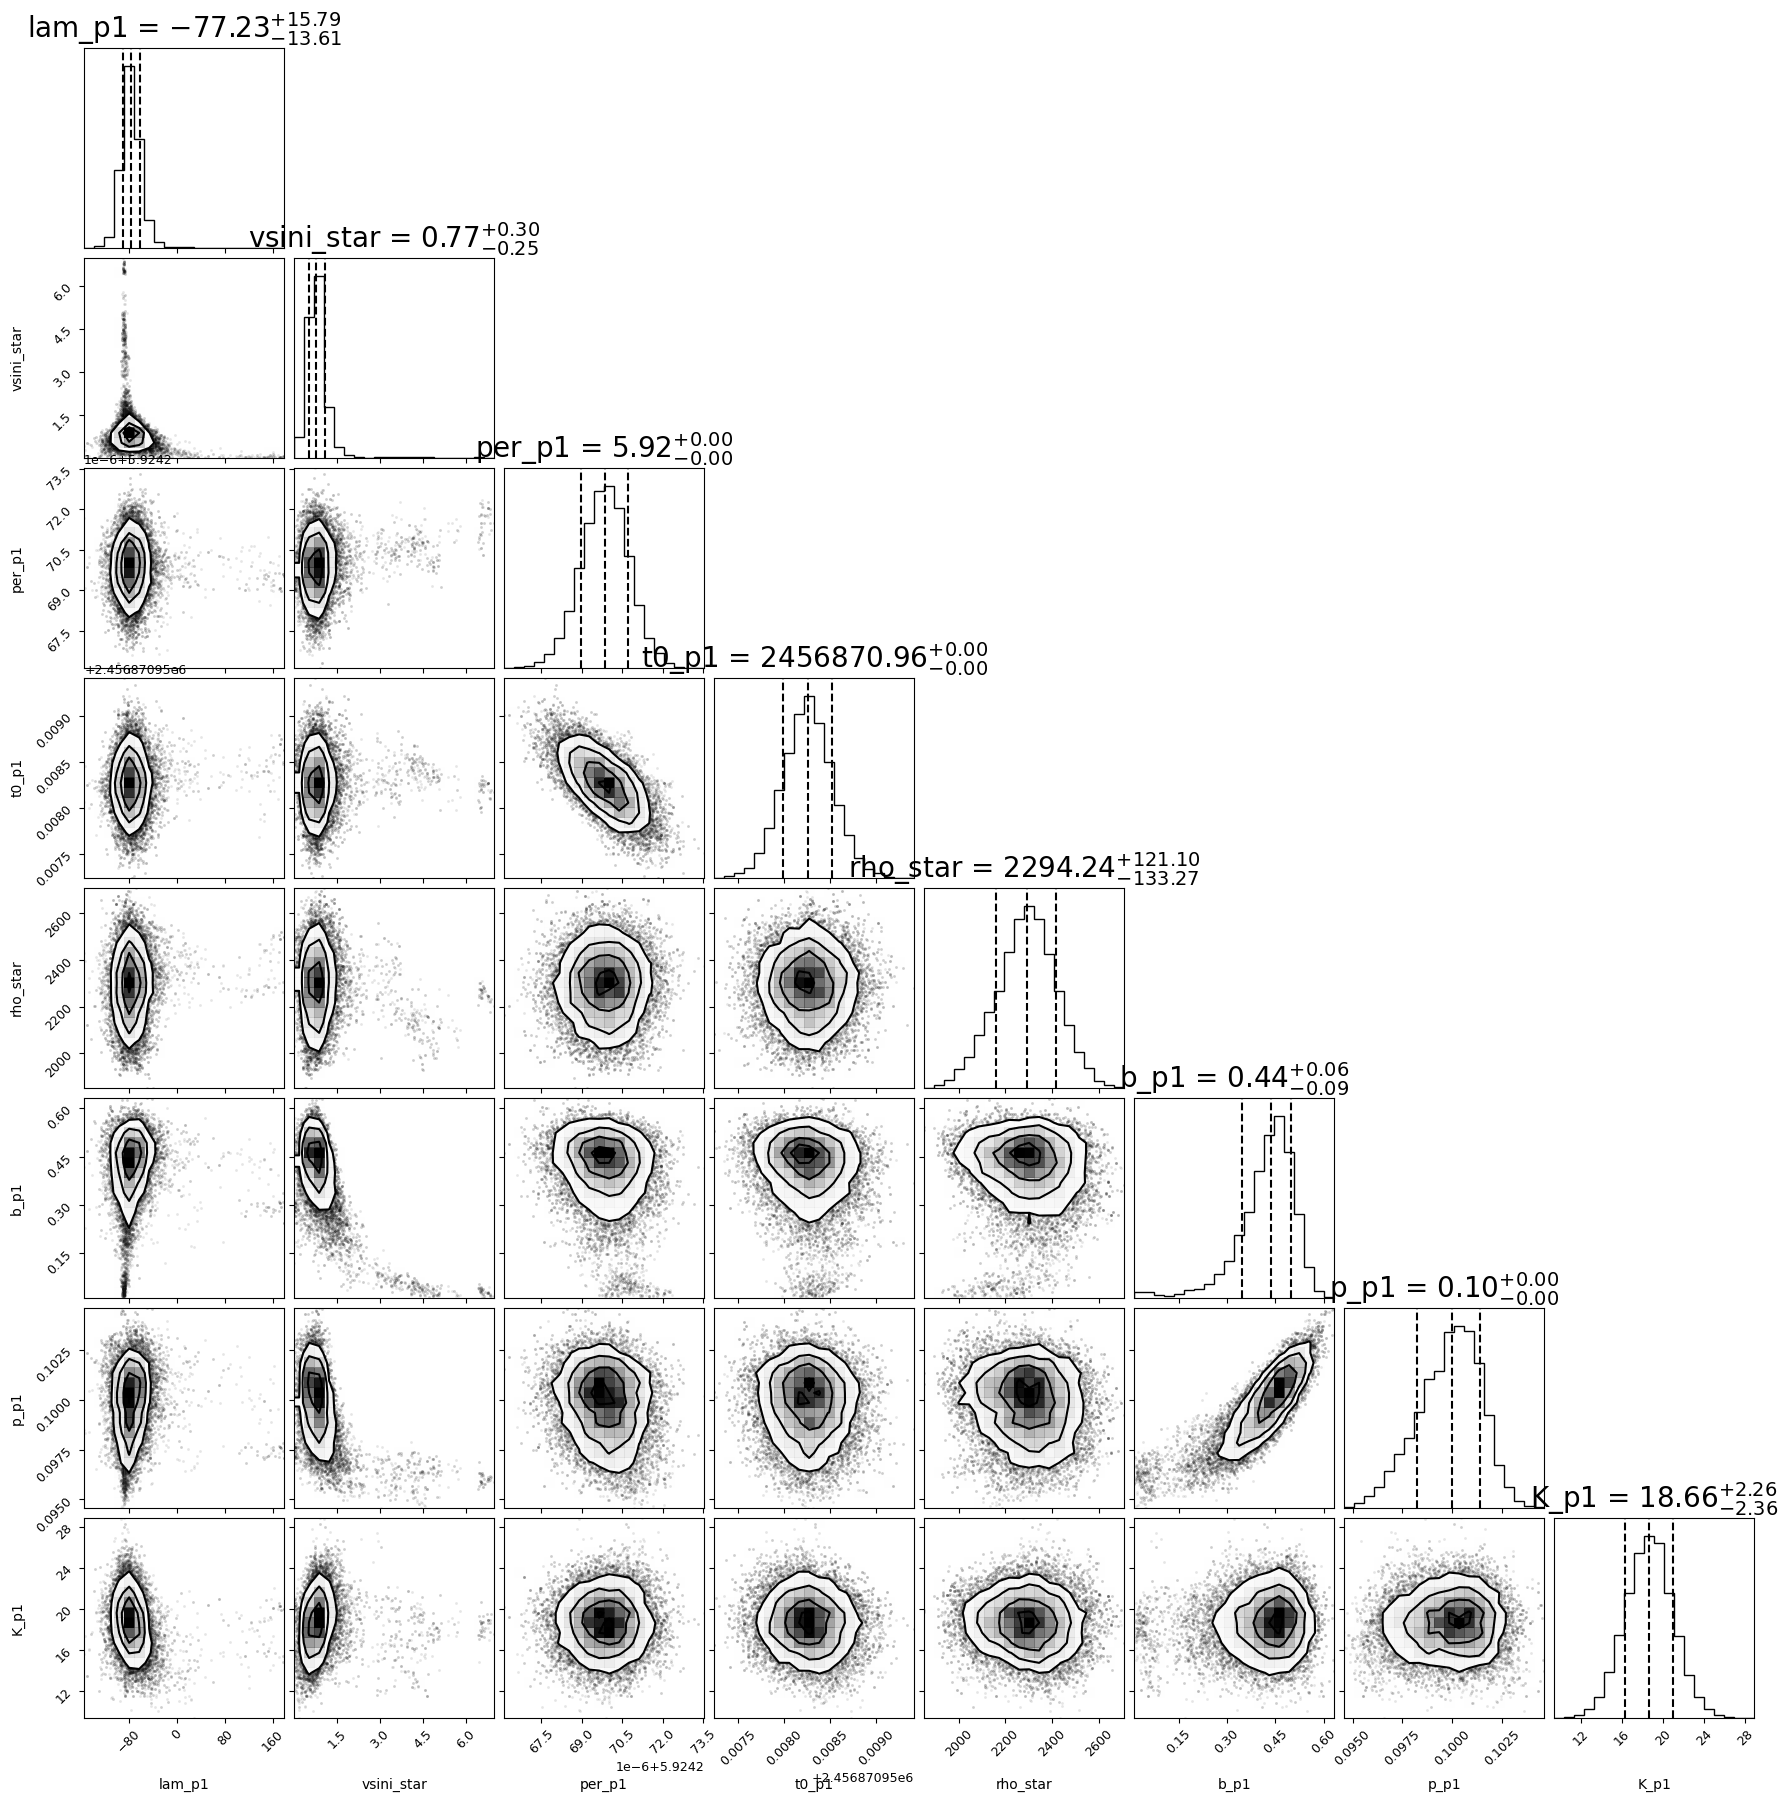

In [58]:
import corner

to_corner = my_post.chain[["lam_p1", "vsini_star", "per_p1", "t0_p1", "rho_star", "b_p1", "p_p1","K_p1"]]
corner.corner(to_corner.values,labels=to_corner.columns,quantiles=[0.16, 0.5, 0.84],label_kwargs={"fontsize": 10},
    show_titles=True,
    title_kwargs={"fontsize": 20})
plt.show()